In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from time import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

## Concatenation of tweets

In [3]:
def concat_tweets(df, MAX_SUBGROUP=150, event_type=True):
    """
    For each group of tweets with the same ID/MatchID/PeriodID/EventType,
    We create `MAX_SUBGROUP` subgroups of tweets by concatenating them.
    Therefore if `MAX_SUBGROUP` = 1, we have 1 tweet per ID/MatchID/PeriodID/EventType
    If `MAX_SUBGROUP` = +inf, we have all the tweets in different subgroups.
    """

    ### Grouping tweets who have same timestamp by concatenating them
    df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
    if event_type:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    else:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    df_bis = df_bis.sample(frac=1).reset_index(drop=True)
    return df_bis

## Load Prepocessed Data

In [4]:
# Load training and evaluation datasets from CSV files
df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

# Ensure the 'Tweet' column is of string type
df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)

# Remove rows with null or empty 'Tweet' values
df_train = df_train[df_train["Tweet"].notnull()]
df_train = df_train[df_train["Tweet"].str.strip() != ""]
df_eval = df_eval[df_eval["Tweet"].notnull()]
df_eval = df_eval[df_eval["Tweet"].str.strip() != ""]

# Drop duplicate rows
df_train = df_train.drop_duplicates()
df_eval = df_eval.drop_duplicates()

# Grouping
Group_train = 10
Group_eval = 10
print("Grouping tweets...")
t = time()
df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=Group_eval, event_type=False)
print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

Grouping tweets...
Tweets grouped in 0.79 seconds
--------------------------------------------------



## Splitting Data

In [5]:
print("Splitting data...")
t = time()

train, test = train_test_split(df_train_bis, test_size=0.01, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------



# Embedding

In [6]:
def fit_tfidf_embedding(train_tweets, max_features=2000, ngram_range=(1,1), max_df=0.7, min_df=2, sublinear_tf=False):
    """
    Fit a TF-IDF vectorizer on the training tweets.
    Returns the fitted vectorizer.
    """
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 max_df=max_df,
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit(train_tweets)
    return vectorizer

def tfidf_embedding(tweets, vectorizer):
    """
    Transform tweets into TF-IDF features using a fitted vectorizer.
    """
    return vectorizer.transform(tweets).toarray()

In [7]:
embedding_dim = 2000

print("Embedding...")
t = time()

# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

Embedding...
Data embedded in 10.34 seconds
--------------------------------------------------



## Create Dataset

In [8]:
def create_sets(train, test, train_X, test_X, batch_size = 64):
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)
    # Labels
    train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
    test_y = np.array(test['EventType']).reshape(-1, 1).flatten()
    train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
    test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

    trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
    testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler

In [9]:
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

Creating the datasets...
Datasets created in 0.28 seconds
--------------------------------------------------



## Training with NN

In [ ]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None, weight_1_0=0.5):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > weight_1_0).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)
        # Scheduler
        if scheduler:
            scheduler.step(val_loss / len(test_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

In [ ]:
# Hyperparameters
output_dim = 1
input_dim = embedding_dim
weight_1_0 = 0.55
hidden_dims = [embedding_dim*3,embedding_dim//20, embedding_dim//10]
dropouts = [0.95] * len(hidden_dims)
epochs = 20
lr = 0.001
decay = 1e-5

In [ ]:
# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
scheduler = None

/users/eleves-a/2022/lee.kadz/miniconda3/envs/inf554/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training the model...
Epoch 1/100, Train Loss: 0.8150, Val Loss: 0.6835, Val Accuracy: 0.5888
Epoch 2/100, Train Loss: 0.7032, Val Loss: 0.6831, Val Accuracy: 0.6215
Epoch 3/100, Train Loss: 0.6997, Val Loss: 0.6777, Val Accuracy: 0.6355
Epoch 4/100, Train Loss: 0.6978, Val Loss: 0.6738, Val Accuracy: 0.6495
Epoch 5/100, Train Loss: 0.6922, Val Loss: 0.6688, Val Accuracy: 0.6402
Epoch 6/100, Train Loss: 0.6899, Val Loss: 0.6585, Val Accuracy: 0.6495
Epoch 7/100, Train Loss: 0.6811, Val Loss: 0.6389, Val Accuracy: 0.6589
Epoch 8/100, Train Loss: 0.6692, Val Loss: 0.6236, Val Accuracy: 0.7009
Epoch 9/100, Train Loss: 0.6506, Val Loss: 0.5870, Val Accuracy: 0.7103
Epoch 10/100, Train Loss: 0.6300, Val Loss: 0.5462, Val Accuracy: 0.7477
Epoch 11/100, Train Loss: 0.6106, Val Loss: 0.5243, Val Accuracy: 0.7617
Epoch 12/100, Train Loss: 0.5963, Val Loss: 0.5135, Val Accuracy: 0.7617
Epoch 13/100, Train Loss: 0.5822, Val Loss: 0.5041, Val Accuracy: 0.7710
Epoch 14/100, Train Loss: 0.5678, Val 

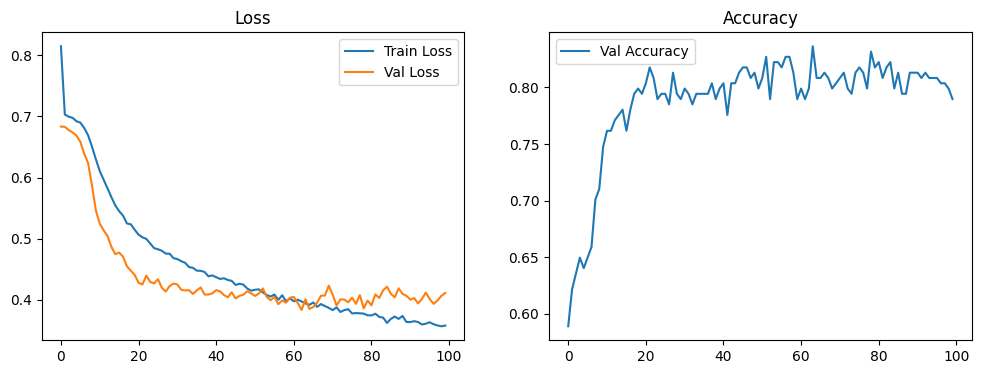

In [15]:
# Training
print("Training the model...")
t = time()
history = train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=epochs, weight_1_0=weight_1_0, scheduler=scheduler)
print(history)
print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")
plot_history(history)

## Training with other models (SVM, LG, RF, XGB)

In [16]:
Y_train = train['EventType']
Y_test = test['EventType']
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, kernel='linear')  # Smaller C increases regularization
svm.fit(train_X, Y_train)
print("SVM Accuracy:", svm.score(test_X, Y_test))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Logistic Regression
print("Testing on Logistic Regression with regularization:")
t = time()
lg = LogisticRegression(max_iter=1000, C=0.1, penalty='l2', solver='liblinear')  # Stronger L2 regularization
lg.fit(train_X, Y_train)
print("Logistic Regression Accuracy:", lg.score(test_X, Y_test))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Random Forest
print("Testing on Random Forest with regularization:")
t = time()
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=3)  # Depth/leaf regularization
rf.fit(train_X, Y_train)
print("Random Forest Accuracy:", rf.score(test_X, Y_test))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized XGBoost
print("Testing on XGBoost with regularization:")
t = time()
xgb = XGBClassifier(eval_metric='logloss', reg_alpha=1, reg_lambda=1, max_depth=6, learning_rate=0.05, n_estimators=200)
xgb.fit(train_X, Y_train)
print("XGBoost Accuracy:", xgb.score(test_X, Y_test))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7570093457943925
Model trained in 226.77 seconds
Testing on Logistic Regression with regularization:
Logistic Regression Accuracy: 0.7616822429906542
Model trained in 0.60 seconds
Testing on Random Forest with regularization:
Random Forest Accuracy: 0.7476635514018691
Model trained in 8.86 seconds
Testing on XGBoost with regularization:
XGBoost Accuracy: 0.7710280373831776
Model trained in 15.69 seconds


## Evaluation for NN

In [17]:
eval_X = tfidf_embedding(df_eval_bis['Tweet'], vectorizer)

In [18]:
def create_sets_for_eval(eval_X, scaler, batch_size = 64):
    # Scale the data
    eval_X = scaler.transform(eval_X)

    evalset = TensorDataset(torch.tensor(eval_X, dtype=torch.float32))

    eval_loader = DataLoader(evalset, batch_size=batch_size, shuffle=False)

    return eval_loader

eval_loader = create_sets_for_eval(eval_X, scaler)

In [19]:
predictions_NN = []
model.eval()
with torch.no_grad():
    for batch in eval_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        predictions_NN.extend(outputs.cpu().numpy().flatten())

In [20]:
predictions_eval = pd.DataFrame({
    'ID': df_eval_bis['ID'],
    'MatchID': df_eval_bis['MatchID'],
    'PeriodID': df_eval_bis['PeriodID'],
    'Predicted_NN': predictions_NN,
})

In [21]:
# Group by ID/PeriodID/MatchID and average the predictions and sort by matchID and then PeriodID
predictions_eval = predictions_eval.groupby(['ID', 'MatchID', 'PeriodID']).mean().reset_index().sort_values(['MatchID', 'PeriodID'])
predictions_eval['Predicted_NN_three'] = (predictions_eval['Predicted_NN'] > weight_1_0).astype(int)

## NN Kaggle submission

In [ ]:
#submission = pd.DataFrame({'ID': predictions_eval['ID'],'EventType': predictions_eval['Predicted_NN_three']})
#submission.to_csv("submission_NN.csv", index=False)

## Evaluation for other models (SVM, LG, RF, XGB)

In [34]:
predictions_lg = lg.predict(eval_X)
predictions_svm = svm.predict(eval_X)
predictions_rf = rf.predict(eval_X)
predictions_xgb = xgb.predict(eval_X)

In [35]:
predictions_eval = pd.DataFrame({
    'ID': df_eval_bis['ID'],
    'MatchID': df_eval_bis['MatchID'],
    'PeriodID': df_eval_bis['PeriodID'],
    'Predicted_NN': predictions_NN,
    'Predicted_LG': predictions_lg,
    'Predicted_SVM': predictions_svm,
    'Predicted_RF': predictions_rf,
    'Predicted_XGB': predictions_xgb
})

In [36]:
predictions_eval = predictions_eval.groupby(['ID', 'MatchID', 'PeriodID']).mean().reset_index().sort_values(['MatchID', 'PeriodID'])
predictions_eval['Predicted_LG_three'] = (predictions_eval['Predicted_LG'] > 0.5).astype(int)
predictions_eval['Predicted_SVM_three'] = (predictions_eval['Predicted_SVM'] > 0.5).astype(int)
predictions_eval['Predicted_RF_three'] = (predictions_eval['Predicted_RF'] > 0.5).astype(int)
predictions_eval['Predicted_XGB_three'] = (predictions_eval['Predicted_XGB'] > 0.5).astype(int)

## Plot Results

Text(0.5, 1.0, 'XGB Predictions')

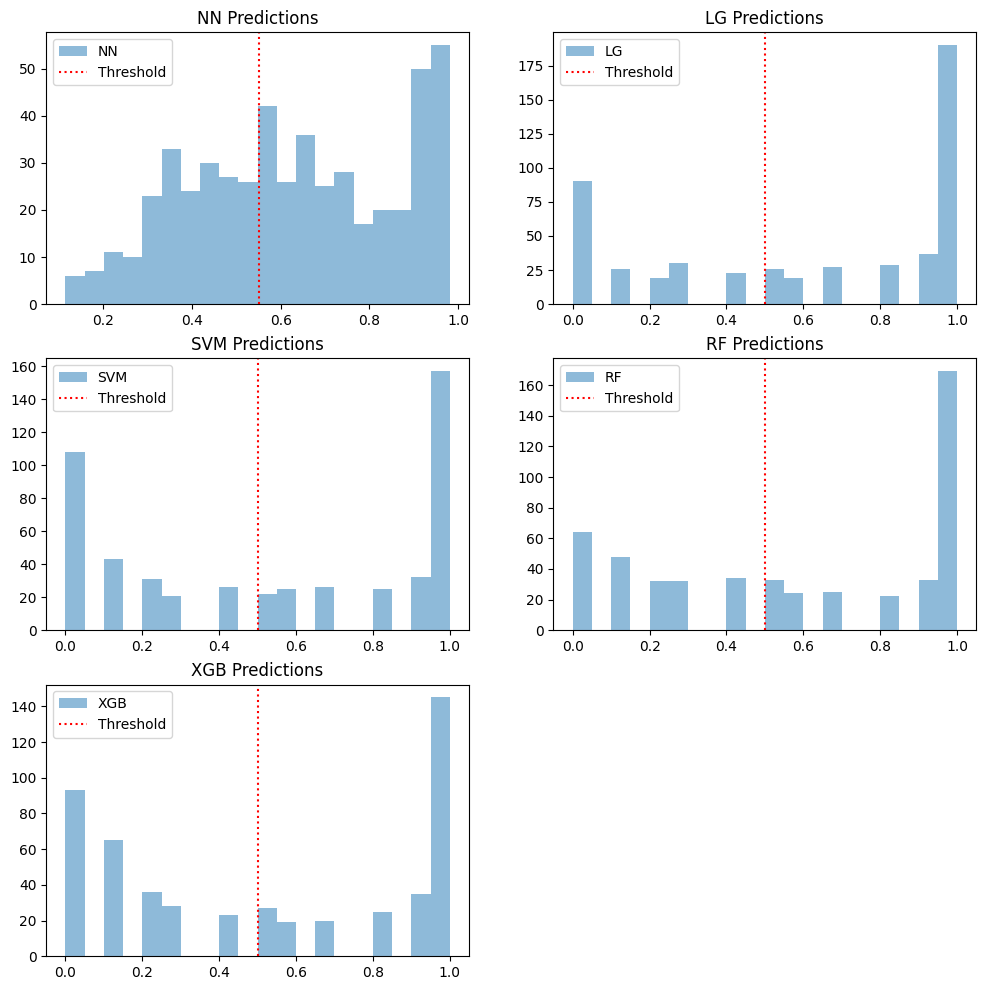

In [37]:
# Histogram of the predictions and the true values as before
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.hist(predictions_eval['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.axvline(weight_1_0, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'NN Predictions')

plt.subplot(3, 2, 2)
plt.hist(predictions_eval['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'LG Predictions')

plt.subplot(3, 2, 3)
plt.hist(predictions_eval['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'SVM Predictions')

plt.subplot(3, 2, 4)
plt.hist(predictions_eval['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'RF Predictions')

plt.subplot(3, 2, 5)
plt.hist(predictions_eval['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'XGB Predictions')